# Import packages

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.api import ARMA


from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.stats.stattools import durbin_watson

from sklearn.metrics import r2_score,mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV




import copy

# Custom functions

In [2]:
def log_transform_inverse(t,x):
    
    return t*np.exp(x)

In [3]:
def diff_for_stationarity(df_input,cols,threshold):
    
    """Checks the series for stationarity then difference it until it is stationary
    (with the given threshold)"""
    
    df = copy.deepcopy(df_input)
    
    
    # Get length of DF
    n = len(df)
    
    # Loop over columns of interest
    for col in cols:
        stationarity = False
        series = list(df[col].astype(float))
        linear_diff = False
        
        try:
        
            counter = 0



            while not stationarity:

                #print(counter)

                # Run ADF test
                adf_test = adfuller(series)
                pval = adf_test[1]

                if pval < threshold:
                    stationarity = True

                else:
                    # Difference the series
                    series = [np.log(series[i]/series[i-1]) for i in range(1,n-counter)]

                    counter += 1
                    
        except:
            
            counter = 0
            stationarity = False
            series = list(df[col].astype(float))
            linear_diff = True

            while not stationarity:

                #print(counter)

                # Run ADF test
                adf_test = adfuller(series)
                pval = adf_test[1]

                if pval < threshold:
                    stationarity = True

                elif counter>1:
                    stationarity = True
                    series = list(df[col].astype(float))
                else:
                    # Difference the series
                    series = [series[i]-series[i-1] for i in range(1,n-counter)]

                    counter += 1
        
        # Create final series and assign it back to the dataframe
        final_series = [None]*counter + series
        df[col] = final_series
        
        if linear_diff:
            type_diff = "linear difference"
        else:
            type_diff = "logarithmic difference"
        
        print("Variable: {} is {}-order integrated ({})!".format(col,counter,type_diff))
        
        
    return df
            

In [4]:
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

In [5]:
def cointegration_test(df, alpha, det_order,diff_lags): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,det_order,diff_lags)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

# Import data

In [6]:
# Import preprocess dataset
df = pd.read_csv('../Data/preprocessed_df.csv',index_col=0)

print(df.head())

      Date  snp500_Open  snp500_High   snp500_Low  snp500_Close  \
0  2011-01  1257.619995  1302.670044  1257.619995   1286.119995   
1  2011-02  1289.140015  1344.069946  1289.140015   1327.219971   
2  2011-03  1328.640015  1332.280029  1249.050049   1325.829956   
3  2011-04  1329.479980  1364.560059  1294.699951   1363.609985   
4  2011-05  1365.209961  1370.579956  1311.800049   1345.199951   

   snp500_Adj Close  snp500_Volume   CAPE   TB10  CPI_growth_rate  TB3MS  \
0       1286.119995    92164940000  22.98  3.374         0.476323   0.15   
1       1327.219971    59223660000  23.49  3.422         0.493137   0.13   
2       1325.829956    89507640000  22.90  3.470         0.975107   0.10   
3       1363.609985    77364810000  23.14  3.290         0.643943   0.06   
4       1345.199951    81708980000  23.06  3.059         0.470419   0.04   

        DFR   DFY     OIL_WTI  EUR_USD  CNY_USD      FTSE100  
0  2.694000  1.05   89.510000   1.3686   0.1513  5862.899902  
1  2.571579  0

# Data preprocessing

## Convert dates to indices

In [7]:
df['Date']= pd.to_datetime(df['Date'])

df = df.set_index('Date')

print(df.head())

            snp500_Open  snp500_High   snp500_Low  snp500_Close  \
Date                                                              
2011-01-01  1257.619995  1302.670044  1257.619995   1286.119995   
2011-02-01  1289.140015  1344.069946  1289.140015   1327.219971   
2011-03-01  1328.640015  1332.280029  1249.050049   1325.829956   
2011-04-01  1329.479980  1364.560059  1294.699951   1363.609985   
2011-05-01  1365.209961  1370.579956  1311.800049   1345.199951   

            snp500_Adj Close  snp500_Volume   CAPE   TB10  CPI_growth_rate  \
Date                                                                         
2011-01-01       1286.119995    92164940000  22.98  3.374         0.476323   
2011-02-01       1327.219971    59223660000  23.49  3.422         0.493137   
2011-03-01       1325.829956    89507640000  22.90  3.470         0.975107   
2011-04-01       1363.609985    77364810000  23.14  3.290         0.643943   
2011-05-01       1345.199951    81708980000  23.06  3.059     

# Exploratory data analysis

In [8]:
print(df.shape)

(117, 16)


/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


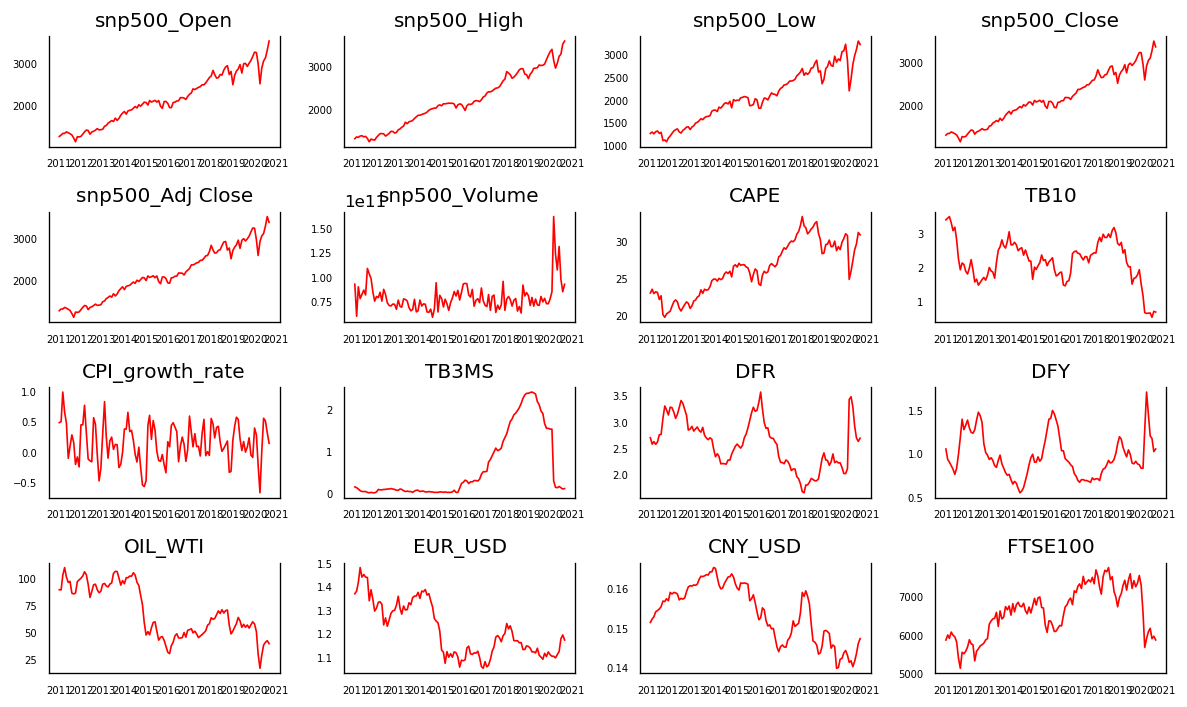

In [9]:
# Plot
fig, axes = plt.subplots(nrows=4, ncols=4, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [10]:
# Global parameters
figsize = (12,5)

sns.set_style("whitegrid")

axis_title_size = 14
axis_label_size = 12
legend_fontsize = 8
save_dpi = 120
ylims = (0,23)

marker_vector = ['o','v','^','<','>','1','2','3','4','8','s','p','*','h','+','x','d','D','X','H','P']

selected_colors = ['beige','black','blue','coral','cyan','deeppink','dimgray','firebrick','gold','green','indigo',
                  'lightsalmon','lime','magenta','orange','purple','red','silver','steelblue','sandybrown',
                   'mediumspringgreen','navy']

y_logscale = True
frequency = 'months' # 'years' , 'months' or 'weeks'
percentages = True

# Derive additional features

## S&P 500 realized price volatility

In [11]:
# Parameters
vol_window_size = 12

# Construct feature
df['SPV'] = df['snp500_Adj Close'].rolling(window=vol_window_size).std()

print(df.head())

            snp500_Open  snp500_High   snp500_Low  snp500_Close  \
Date                                                              
2011-01-01  1257.619995  1302.670044  1257.619995   1286.119995   
2011-02-01  1289.140015  1344.069946  1289.140015   1327.219971   
2011-03-01  1328.640015  1332.280029  1249.050049   1325.829956   
2011-04-01  1329.479980  1364.560059  1294.699951   1363.609985   
2011-05-01  1365.209961  1370.579956  1311.800049   1345.199951   

            snp500_Adj Close  snp500_Volume   CAPE   TB10  CPI_growth_rate  \
Date                                                                         
2011-01-01       1286.119995    92164940000  22.98  3.374         0.476323   
2011-02-01       1327.219971    59223660000  23.49  3.422         0.493137   
2011-03-01       1325.829956    89507640000  22.90  3.470         0.975107   
2011-04-01       1363.609985    77364810000  23.14  3.290         0.643943   
2011-05-01       1345.199951    81708980000  23.06  3.059     

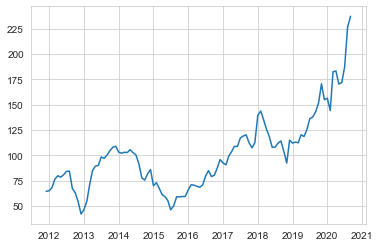

In [12]:
plt.plot(df['SPV'])

## Drop unused features

In [13]:
# Drop
df= df.drop(['snp500_Open','snp500_High','snp500_Low','snp500_Close','snp500_Volume'], axis=1)

print(df.head())

            snp500_Adj Close   CAPE   TB10  CPI_growth_rate  TB3MS       DFR  \
Date                                                                           
2011-01-01       1286.119995  22.98  3.374         0.476323   0.15  2.694000   
2011-02-01       1327.219971  23.49  3.422         0.493137   0.13  2.571579   
2011-03-01       1325.829956  22.90  3.470         0.975107   0.10  2.620435   
2011-04-01       1363.609985  23.14  3.290         0.643943   0.06  2.568000   
2011-05-01       1345.199951  23.06  3.059         0.470419   0.04  2.612857   

             DFY     OIL_WTI  EUR_USD  CNY_USD      FTSE100  SPV  
Date                                                              
2011-01-01  1.05   89.510000   1.3686   0.1513  5862.899902  NaN  
2011-02-01  0.93   89.366000   1.3802   0.1522  5994.000000  NaN  
2011-03-01  0.90  102.916087   1.4166   0.1527  5908.799805  NaN  
2011-04-01  0.86  110.042857   1.4802   0.1540  6069.899902  NaN  
2011-05-01  0.82  101.251364   1.4396

## Drop NaNs

In [14]:
# Drop rows with NaN value
df = df.dropna()

print(df.head())

print(df.shape)

            snp500_Adj Close   CAPE   TB10  CPI_growth_rate  TB3MS       DFR  \
Date                                                                           
2011-12-01       1257.599976  20.52  1.876        -0.246652   0.01  3.272381   
2012-01-01       1312.410034  21.21  1.795         0.440019   0.03  3.262000   
2012-02-01       1365.680054  21.80  1.974         0.440297   0.09  3.174500   
2012-03-01       1408.469971  22.05  2.214         0.759456   0.08  3.060455   
2012-04-01       1397.910034  21.78  1.919         0.302103   0.08  3.140952   

             DFY     OIL_WTI  EUR_USD  CNY_USD      FTSE100        SPV  
Date                                                                    
2011-12-01  1.32   98.612273   1.2948   0.1589  5572.299805  64.329768  
2012-01-01  1.38  100.148636   1.3078   0.1585  5681.600098  64.973509  
2012-02-01  1.29  102.262857   1.3326   0.1589  5871.500000  68.223263  
2012-03-01  1.24  106.150455   1.3344   0.1588  5768.500000  76.287039  
2

# Causality tests

## Granger-causality

In [15]:
# Parameters
maxlag=12
test = 'ssr_chi2test'

# Run the test
granger_df = grangers_causation_matrix(df, variables = df.columns) 

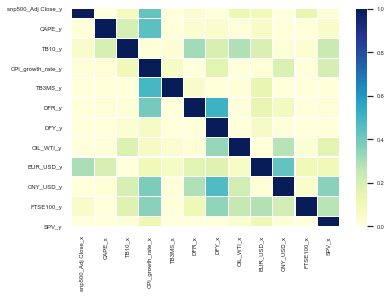

In [16]:
# Visualise connections
sns.set(font_scale=0.5)
ax = sns.heatmap(granger_df, linewidth=0.1, cmap="YlGnBu",) #cbar_kws={'format': '%.0f%%'})
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
#ax.spines["top"].set_alpha(0)
ax.tick_params(labelsize=6)

plt.savefig('../Figures/Granger_causality_df.pdf',
bbox_inches='tight',dpi=save_dpi)

## Cointegration test

In [17]:
# Parameters
threshold = 0.01
det_order = -1
diff_lags = 5

# Run the test
cointegration_test(df=df,alpha=threshold,det_order=det_order,diff_lags=diff_lags)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
snp500_Adj Close ::  872.16    > 326.9716  =>   True
CAPE   ::  684.15    > 277.9962  =>   True
TB10   ::  529.97    > 232.8291  =>   True
CPI_growth_rate ::  413.04    > 191.8122  =>   True
TB3MS  ::  310.31    > 154.7977  =>   True
DFR    ::  221.91    > 121.7375  =>   True
DFY    ::  158.61    > 92.7136   =>   True
OIL_WTI ::  105.62    > 67.6367   =>   True
EUR_USD ::  62.08     > 46.5716   =>   True
CNY_USD ::  31.32     > 29.5147   =>   True
FTSE100 ::  14.31     > 16.364    =>   False
SPV    ::  0.02      > 6.9406    =>   False


# Transform variables for stationarity

In [18]:
df.columns

Index(['snp500_Adj Close', 'CAPE', 'TB10', 'CPI_growth_rate', 'TB3MS', 'DFR',
       'DFY', 'OIL_WTI', 'EUR_USD', 'CNY_USD', 'FTSE100', 'SPV'],
      dtype='object')

In [19]:
# Parameters
selected_cols = ['snp500_Adj Close', 'CAPE', 'TB10', 'CPI_growth_rate', 'TB3MS',
       'DFR', 'DFY', 'OIL_WTI', 'EUR_USD', 'CNY_USD', 'FTSE100', 'SPV']
stationarity_threshold = 0.01

# Run stationarity checks
df_stationer = diff_for_stationarity(df_input=df,cols=selected_cols,threshold=stationarity_threshold)

Variable: snp500_Adj Close is 1-order integrated (logarithmic difference)!
Variable: CAPE is 1-order integrated (logarithmic difference)!
Variable: TB10 is 1-order integrated (logarithmic difference)!
Variable: CPI_growth_rate is 0-order integrated (logarithmic difference)!
Variable: TB3MS is 0-order integrated (logarithmic difference)!
Variable: DFR is 2-order integrated (linear difference)!
Variable: DFY is 1-order integrated (logarithmic difference)!
Variable: OIL_WTI is 1-order integrated (logarithmic difference)!
Variable: EUR_USD is 1-order integrated (logarithmic difference)!
Variable: CNY_USD is 1-order integrated (logarithmic difference)!
Variable: FTSE100 is 1-order integrated (logarithmic difference)!
Variable: SPV is 1-order integrated (logarithmic difference)!


/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in log


In [20]:
# Inspect the dataset
print(df_stationer.head())

            snp500_Adj Close      CAPE      TB10  CPI_growth_rate  TB3MS  \
Date                                                                       
2011-12-01               NaN       NaN       NaN        -0.246652   0.01   
2012-01-01          0.042660  0.033073 -0.044137         0.440019   0.03   
2012-02-01          0.039787  0.027437  0.095057         0.440297   0.09   
2012-03-01          0.030851  0.011403  0.114739         0.759456   0.08   
2012-04-01         -0.007526 -0.012320 -0.142997         0.302103   0.08   

                 DFR       DFY   OIL_WTI   EUR_USD   CNY_USD   FTSE100  \
Date                                                                     
2011-12-01       NaN       NaN       NaN       NaN       NaN       NaN   
2012-01-01       NaN  0.044452  0.015460  0.009990 -0.002520  0.019425   
2012-02-01 -0.077119 -0.067441  0.020891  0.018786  0.002520  0.032877   
2012-03-01 -0.026545 -0.039531  0.037311  0.001350 -0.000630 -0.017698   
2012-04-01  0.194543 -0

In [21]:
# Drop rows with NaN value
df_stationer = df_stationer.dropna()

print(df_stationer.head())

print(df_stationer.shape)

            snp500_Adj Close      CAPE      TB10  CPI_growth_rate  TB3MS  \
Date                                                                       
2012-02-01          0.039787  0.027437  0.095057         0.440297   0.09   
2012-03-01          0.030851  0.011403  0.114739         0.759456   0.08   
2012-04-01         -0.007526 -0.012320 -0.142997         0.302103   0.08   
2012-05-01         -0.064699 -0.039331 -0.205197        -0.117348   0.09   
2012-06-01          0.038793 -0.018800  0.049917        -0.146640   0.09   

                 DFR       DFY   OIL_WTI   EUR_USD   CNY_USD   FTSE100  \
Date                                                                     
2012-02-01 -0.077119 -0.067441  0.020891  0.018786  0.002520  0.032877   
2012-03-01 -0.026545 -0.039531  0.037311  0.001350 -0.000630 -0.017698   
2012-04-01  0.194543 -0.008097 -0.027372 -0.007824 -0.001891 -0.005336   
2012-05-01  0.044004  0.032003 -0.088812 -0.068939 -0.009509 -0.075433   
2012-06-01  0.008139  0

# Create training sample and test sample

In [22]:
n = len(df_stationer)
testsize = 0.2

test_obs = int(n*testsize)
df_train, df_test = df_stationer[0:-test_obs], df_stationer[-test_obs:]

# Check size
print(df_train.shape)  # (84, 12)
print(df_test.shape)  # (20, 12)

(84, 12)
(20, 12)


# Models

## ARMA(p,q)

In [23]:
# Fit the model
res = sm.tsa.arma_order_select_ic(df_train['snp500_Adj Close'], ic=["aic", "bic","hqic"], trend="nc")

/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [24]:
print(res) # AR(1) is the best

{'aic':             0           1           2
0         NaN -334.935483 -333.000862
1 -335.024622 -333.354286 -331.464179
2 -333.106809 -331.452662 -329.345250
3 -331.594340 -329.642253 -328.185138
4 -329.854121 -335.353087 -328.403034, 'bic':             0           1           2
0         NaN -330.073849 -325.708411
1 -330.162988 -326.061836 -321.740912
2 -325.814359 -321.729394 -317.191166
3 -321.871073 -317.488169 -313.600237
4 -317.700037 -320.768186 -311.387316, 'hqic':             0           1           2
0         NaN -332.981147 -330.069358
1 -333.070286 -330.422783 -327.555508
2 -330.175306 -327.543990 -324.459411
3 -327.685669 -324.756413 -322.322131
4 -324.968281 -329.490080 -321.562858, 'aic_min_order': (4, 1), 'bic_min_order': (1, 0), 'hqic_min_order': (1, 0)}


In [25]:
# Parameters
order = (1,0)

# Initialise model
arma_model = ARMA(df_train['snp500_Adj Close'],order)

/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [26]:
# Fit the model with the selected order
arma_model_fitted = arma_model.fit()
arma_model_fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:       snp500_Adj Close   No. Observations:                   84
Model:                     ARMA(1, 0)   Log Likelihood                 173.708
Method:                       css-mle   S.D. of innovations              0.031
Date:                Fri, 04 Dec 2020   AIC                           -341.416
Time:                        16:11:43   BIC                           -334.123
Sample:                    02-01-2012   HQIC                          -338.484
                         - 01-01-2019                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.0084      0.003      3.055      0.003       0.003       0.014
ar.L1.snp500_Adj Close    -0.2173      0.110     -1.982      0.051      -0.432      -0.002
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -4.6009           +0.0000j            4.6009            0.5000
-----------------------------------------------------------------------------
"""

In [27]:
arma_model_fitted.params[1]

-0.21734732492423364

In [28]:
# Forecasting
arma_preds = []


for i in range(0,test_obs):
    locat = -test_obs-1+i
    
    pred = arma_model_fitted.params[1]*df_stationer['snp500_Adj Close'].iloc[locat] + arma_model_fitted.params[0]
    arma_preds.append(pred)

## LASSO

In [29]:
Y_train = np.asarray(df_train['snp500_Adj Close'].iloc[1:])
Y_test = np.asarray(df_test['snp500_Adj Close'])

In [30]:
df_train

,snp500_Adj Close,CAPE,TB10,CPI_growth_rate,TB3MS,DFR,DFY,OIL_WTI,EUR_USD,CNY_USD,FTSE100,SPV
Date,,,,,,,,,,,,
2012-02-01,0.039787,0.027437,0.095057,0.440297,0.09,-0.077119,-0.067441,0.020891,0.018786,0.002520,0.032877,0.048806
2012-03-01,0.030851,0.011403,0.114739,0.759456,0.08,-0.026545,-0.039531,0.037311,0.001350,-0.000630,-0.017698,0.111717
2012-04-01,-0.007526,-0.012320,-0.142997,0.302103,0.08,0.194543,-0.008097,-0.027372,-0.007824,-0.001891,-0.005336,0.044221
2012-05-01,-0.064699,-0.039331,-0.205197,-0.117348,0.09,0.044004,0.032003,-0.088812,-0.068939,-0.009509,-0.075433,-0.016896
2012-06-01,0.038793,-0.018800,0.049917,-0.146640,0.09,0.008139,0.083067,-0.137579,0.024144,0.002545,0.045968,0.027873
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-09-01,0.004285,0.007076,0.069226,0.116203,2.13,0.027942,0.011173,0.031800,0.000689,-0.004796,0.010413,0.019109
2018-10-01,-0.071929,-0.049649,0.027037,0.176676,2.25,0.031191,0.032790,0.008029,-0.025917,-0.015923,-0.052217,-0.092363
2018-11-01,0.017702,-0.027435,-0.050809,-0.334935,2.33,0.160110,0.072571,-0.223732,0.000442,0.002091,-0.020967,-0.120068


In [31]:
df_train_temp = df_train.shift(1)

In [32]:
df_train_temp = df_train_temp.dropna()

print(df_train_temp.head())

            snp500_Adj Close      CAPE      TB10  CPI_growth_rate  TB3MS  \
Date                                                                       
2012-03-01          0.039787  0.027437  0.095057         0.440297   0.09   
2012-04-01          0.030851  0.011403  0.114739         0.759456   0.08   
2012-05-01         -0.007526 -0.012320 -0.142997         0.302103   0.08   
2012-06-01         -0.064699 -0.039331 -0.205197        -0.117348   0.09   
2012-07-01          0.038793 -0.018800  0.049917        -0.146640   0.09   

                 DFR       DFY   OIL_WTI   EUR_USD   CNY_USD   FTSE100  \
Date                                                                     
2012-03-01 -0.077119 -0.067441  0.020891  0.018786  0.002520  0.032877   
2012-04-01 -0.026545 -0.039531  0.037311  0.001350 -0.000630 -0.017698   
2012-05-01  0.194543 -0.008097 -0.027372 -0.007824 -0.001891 -0.005336   
2012-06-01  0.044004  0.032003 -0.088812 -0.068939 -0.009509 -0.075433   
2012-07-01  0.008139  0

In [33]:
X_train = np.asarray(df_train_temp)
X_test = np.asarray(df_stationer.iloc[-len(Y_test)-1:-1,:])

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(83, 12)
(20, 12)
(83,)
(20,)


In [34]:
lasso = Lasso()

# Set parameters for gridsearch
alphas = np.array([0.000007, 0.00002, 0.00004, 0.00005,0.00008,0.0001,0.00012, 0.00015,0.0002,0.00025,0.0003,
                   0.0004,0.0005,0.0006,0.0007])

lasso_parameters = {'alpha':alphas, 'fit_intercept':[False]}

# Run gridsearch
lasso_grid = GridSearchCV(lasso, lasso_parameters, n_jobs=3, 
                   cv=5,
                   scoring='neg_mean_squared_error',
                   verbose=2, refit=True)

# Fit the model
lasso_grid.fit(X_train, Y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  75 out of  75 | elapsed:    2.4s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='warn', n_jobs=3,
             param_grid={'alpha': array([7.0e-06, 2.0e-05, 4.0e-05, 5.0e-05, 8.0e-05, 1.0e-04, 1.2e-04,
       1.5e-04, 2.0e-04, 2.5e-04, 3.0e-04, 4.0e-04, 5.0e-04, 6.0e-04,
       7.0e-04]),
                         'fit_intercept': [False]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=2)

In [35]:
print(lasso_grid.best_estimator_.coef_)
print(lasso_grid.best_estimator_.intercept_)

# TB3MS and CPI_growth_rate are significant

[-0.         -0.         -0.          0.00201505  0.00237282 -0.
 -0.          0.         -0.         -0.          0.          0.        ]
0.0


In [36]:
lasso_grid.best_params_

{'alpha': 0.0007, 'fit_intercept': False}

In [37]:
lasso_grid.best_estimator_

Lasso(alpha=0.0007, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [38]:
# Predict with the final model for the validation set
lasso_pred = lasso_grid.predict(X_test)

In [39]:
lasso_pred

array([ 0.00600778,  0.00652282,  0.00683154,  0.00671429,  0.00600509,
        0.00518915,  0.00531963,  0.00461679,  0.0046425 ,  0.00437584,
        0.00354609,  0.00347082,  0.00438848,  0.00415894,  0.00024955,
       -0.00101526,  0.0003124 ,  0.0014823 ,  0.00132773,  0.00087267])

## VAR

In [62]:
# Initialise model
var_model = VAR(df_train)

/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [63]:
# Parameters
maxvarlags = 5

# Model selection
x = var_model.select_order(maxlags=maxvarlags)
x.summary() # Order 1 seems to be the best

,AIC,BIC,FPE,HQIC
0,-68.29,-67.93,2.198e-30,-68.15
1,-74.26,-69.58*,5.800e-33*,-72.39*
2,-73.80,-64.80,1.168e-32,-70.19
3,-73.00,-59.68,5.135e-32,-67.66
4,-74.00,-56.36,9.121e-32,-66.93
5,-80.31*,-58.35,5.825e-33,-71.51


In [64]:
# Fit the model with the selected order
model_fitted = var_model.fit(1)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 04, Dec, 2020
Time:                     16:17:22
--------------------------------------------------------------------
No. of Equations:         12.0000    BIC:                   -69.7248
Nobs:                     83.0000    HQIC:                  -72.4446
Log likelihood:           1824.99    FPE:                5.72847e-33
AIC:                     -74.2711    Det(Omega_mle):     9.99357e-34
--------------------------------------------------------------------
Results for equation snp500_Adj Close
                         coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------
const                       0.016476         0.004962            3.321           0.001
L1.snp500_Adj Close        -0.348485         0.195648           -1.781           0.075
L1.CAPE                  

In [65]:
# DW-test for serial autocorrelation
out = durbin_watson(model_fitted.resid)

for col, val in zip(df_stationer.columns, out):
    print(col, ':', round(val, 2))
    
# They are close to 2 so it's fine

snp500_Adj Close : 2.17
CAPE : 2.2
TB10 : 1.93
CPI_growth_rate : 1.59
TB3MS : 1.43
DFR : 2.15
DFY : 2.04
OIL_WTI : 1.99
EUR_USD : 1.88
CNY_USD : 1.92
FTSE100 : 2.0
SPV : 1.85


In [66]:
# Forecast with the model
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input = df_train.values[-lag_order:]
forecast_input

1


array([[ 7.57421520e-02,  3.17628642e-03, -1.99292176e-02,
         1.90659667e-01,  2.37000000e+00, -8.89147870e-02,
         6.95932918e-02,  5.44605339e-02, -2.09460715e-03,
         2.58166512e-02,  3.51645786e-02, -2.58088421e-02]])

In [67]:
# Parameters
forecast_horizon = 1
target_name = 'snp500_Adj Close'
target_loc = list(df.columns).index(target_name)

# Forecasting
y_true = df_test[target_name].iloc[forecast_horizon-1:]
y_preds = []
counter = 0

for i in range(forecast_horizon-1,test_obs):
    
    #print("Round: {}".format(i))
    
    if counter == 0 :
        
        forecast_input = df_train.iloc[len(df_train)-(lag_order-counter):,:]
        
        # Convert it to numpy array
        forecast_input = forecast_input.values
        
        #print(forecast_input)
        
    elif counter < lag_order:
        input_part1 = df_train.iloc[len(df_train)-(lag_order-counter):,:]
        
        input_part2 = df_test.iloc[:counter,:]
        
        forecast_input = pd.concat([input_part1,input_part2], axis=0)
        
        # Convert it to numpy array
        forecast_input = forecast_input.values
        
        #print(forecast_input)
        
        
    else:
        forecast_input = df_test.values[(counter-lag_order):counter]
        
        #print(forecast_input)
    
    
    
    #print(forecast_input)
        
    # Forecast step
    fc = model_fitted.forecast(y=forecast_input, steps=forecast_horizon)
    
    # Find the target value
    pred = fc[forecast_horizon-1,target_loc]
    #print(pred)
    y_preds.append(pred)
    
    # Increment counter
    counter += 1

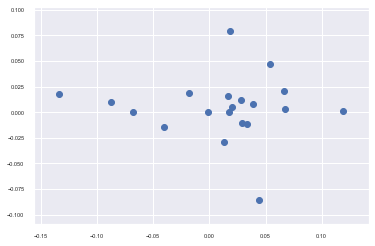

In [68]:
plt.scatter(y_true,y_preds)
plt.show()

In [69]:
# Transform predicted S&P 500 to the original series
nt = len(y_preds)
true_vals = list(df['snp500_Adj Close'].iloc[-nt-forecast_horizon:])

y_preds_transformed = [log_transform_inverse(t=true_vals[i],x=y_preds[i]) for i in range(0,nt)]


In [70]:
# ARMA
arma_preds_transformed = [log_transform_inverse(t=true_vals[i],x=arma_preds[i]) for i in range(0,nt)]

In [71]:
# LASSO 
lasso_pred_transformed = [log_transform_inverse(t=true_vals[i],x=lasso_pred[i]) for i in range(0,nt)]

In [72]:
# Use historical average prediction as baseline
window_size = 12

y_baseline_pred = [np.nanmean(df['snp500_Adj Close'].iloc[-(nt+window_size-i):-(nt-i)]) for i in range(0,nt)]

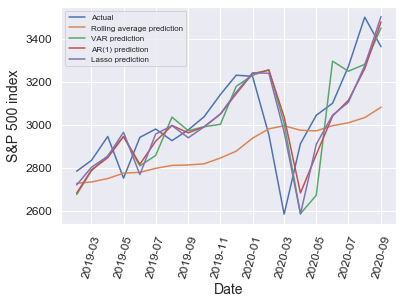

In [74]:
# ONLY WORKS WITH LAG 1!!

df_test_for_viz = copy.deepcopy(df_test)

df_test_for_viz['VAR'] = y_preds_transformed
df_test_for_viz['HIST_AVG'] = y_baseline_pred
df_test_for_viz['ACTUAL'] = true_vals[forecast_horizon:]
df_test_for_viz['ARMA'] = arma_preds_transformed
df_test_for_viz['LASSO'] = lasso_pred_transformed

plt.plot(df_test_for_viz['ACTUAL'],label="Actual")
plt.plot(df_test_for_viz['HIST_AVG'],label="Rolling average prediction")
plt.plot(df_test_for_viz['VAR'],label="VAR prediction")
plt.plot(df_test_for_viz['ARMA'],label="AR(1) prediction")
plt.plot(df_test_for_viz['LASSO'],label="Lasso prediction")

plt.tick_params(axis='both', which='major', labelsize=axis_label_size)
plt.xticks(rotation=75) 
plt.ylabel("S&P 500 index", fontsize=axis_title_size)
plt.xlabel("Date", fontsize=axis_title_size)



plt.legend(loc='upper left',fontsize=legend_fontsize)
plt.savefig('../Figures/Model_fit_comparison.pdf',
bbox_inches='tight',dpi=save_dpi)
plt.show()

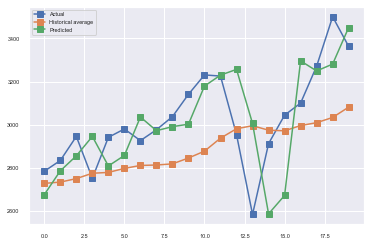

In [71]:
plt.plot(true_vals[forecast_horizon:],label="Actual",marker="s")
plt.plot(y_baseline_pred,label="Historical average",marker="s")
plt.plot(y_preds_transformed,label="Predicted",marker="s")
plt.legend(loc='upper left')
plt.show()

In [75]:
# Evaluation
var_r2 = r2_score(true_vals[forecast_horizon:], y_preds_transformed)
var_mse = mean_squared_error(true_vals[forecast_horizon:], y_preds_transformed)
print("VAR R^2: {}".format(var_r2))
print("VAR MSE: {}".format(var_mse))

baseline_hist_avg_r2 = r2_score(true_vals[forecast_horizon:], y_baseline_pred)
baseline_hist_avg_mse = mean_squared_error(true_vals[forecast_horizon:], y_baseline_pred)
print("Historical average R^2: {}".format(baseline_hist_avg_r2))
print("Historical average MSE: {}".format(baseline_hist_avg_mse))

arma_r2 = r2_score(true_vals[forecast_horizon:], arma_preds_transformed)
arma_mse = mean_squared_error(true_vals[forecast_horizon:], arma_preds_transformed)
print("AR(1) R^2: {}".format(arma_r2))
print("AR(1) MSE: {}".format(arma_mse))

lasso_r2 = r2_score(true_vals[forecast_horizon:], lasso_pred_transformed)
lasso_mse = mean_squared_error(true_vals[forecast_horizon:], lasso_pred_transformed)
print("Lasso R^2: {}".format(lasso_r2))
print("Lasso MSE: {}".format(lasso_mse))

VAR R^2: 0.19208473976454865
VAR MSE: 36779.52301476813
Historical average R^2: -0.15188675212997205
Historical average MSE: 52438.47640410221
AR(1) R^2: 0.36211192461730857
AR(1) MSE: 29039.20782799241
Lasso R^2: 0.37805811531886724
Lasso MSE: 28313.27366537375


## PCA

## Horizon-effects

In [76]:
var_mses = []
avg_mses = []
forecast_horizons = np.arange(1,6,1)



for forecast_horizon in forecast_horizons:
    target_name = 'snp500_Adj Close'
    target_loc = list(df.columns).index(target_name)

    # Forecasting
    y_true = df_test[target_name].iloc[forecast_horizon-1:]
    y_preds = []
    counter = 0

    for i in range(forecast_horizon-1,test_obs):

        #print("Round: {}".format(i))

        if counter == 0 :

            forecast_input = df_train.iloc[len(df_train)-(lag_order-counter):,:]

            # Convert it to numpy array
            forecast_input = forecast_input.values

            #print(forecast_input)

        elif counter < lag_order:
            input_part1 = df_train.iloc[len(df_train)-(lag_order-counter):,:]

            input_part2 = df_test.iloc[:counter,:]

            forecast_input = pd.concat([input_part1,input_part2], axis=0)

            # Convert it to numpy array
            forecast_input = forecast_input.values

            #print(forecast_input)


        else:
            forecast_input = df_test.values[(counter-lag_order):counter]

            #print(forecast_input)



        #print(forecast_input)

        # Forecast step
        fc = model_fitted.forecast(y=forecast_input, steps=forecast_horizon)

        # Find the target value
        pred = fc[forecast_horizon-1,target_loc]
        #print(pred)
        y_preds.append(pred)

        # Increment counter
        counter += 1

    # Transform predicted S&P 500 to the original series
    nt = len(y_preds)
    true_vals = list(df['snp500_Adj Close'].iloc[-nt-forecast_horizon:])

    y_preds_transformed = [log_transform_inverse(t=true_vals[i],x=y_preds[i]) for i in range(0,nt)]

    # Use historical average prediction as baseline
    window_size = 12

    y_baseline_pred = [np.nanmean(df['snp500_Adj Close'].iloc[-(nt+window_size-i):-(nt-i)]) for i in range(0,nt)]

    var_mse = mean_squared_error(true_vals[forecast_horizon:], y_preds_transformed)
    var_mses.append(var_mse)

    baseline_hist_avg_mse = mean_squared_error(true_vals[forecast_horizon:], y_baseline_pred)
    avg_mses.append(baseline_hist_avg_mse)

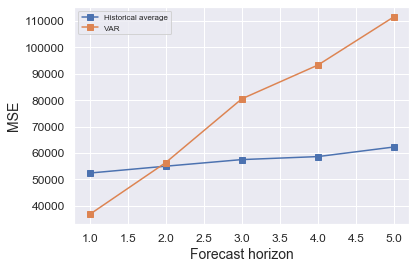

In [77]:
plt.plot(forecast_horizons,avg_mses,label="Historical average",marker="s")
plt.plot(forecast_horizons,var_mses,label="VAR",marker="s")
plt.ylabel("MSE")
plt.xlabel("Forecast horizon (in months)")
plt.legend(loc='upper left',fontsize=legend_fontsize)
plt.tick_params(axis='both', which='major', labelsize=axis_label_size)
plt.ylabel("MSE", fontsize=axis_title_size)
plt.xlabel("Forecast horizon", fontsize=axis_title_size)
plt.savefig('../Figures/horizon_effects.pdf',
bbox_inches='tight',dpi=save_dpi)
plt.show()

# Support

In [12]:

adf_test = adfuller(list(df['snp500_Adj Close']))

print ("ADF = " + str(adf_test[0]))
print ("p-value = " +str(adf_test[1]))

# Not stationary!!

ADF = -0.10605268883540019
p-value = 0.9488323151711808


In [14]:
# Let's check after transformation
log_return = [np.log(df['snp500_Adj Close'].iloc[i]/df['snp500_Adj Close'].iloc[i-1])\
              for i in range(1,len(df['snp500_Adj Close']))]

adf_test = adfuller(log_return)

print ("ADF = " + str(adf_test[0]))
print ("p-value = " +str(adf_test[1]))

# That is already stationary!

ADF = -7.376640172254899
p-value = 8.687528002588852e-11


In [50]:
df.DFR.loc[12]

3.2620000000000005

In [51]:
[]+[1,2]

[1, 2]

In [52]:
[None]*0

[]

In [53]:
np.max(df.DFR)

3.559